In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import random
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
from sklearn import metrics
import squarify

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from weights_parser import WeightsParser

from models import LogisticRegressionWithSummaries_Wrapper, LogisticRegressionWithSummariesAndBottleneck_Wrapper, LSTM_Baseline

from custom_losses import custom_bce_horseshoe

from preprocess_helpers import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits

from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from itertools import combinations

from tqdm import tqdm
from time import sleep
from helper import *
from param_initializations import *

## Load data

In [2]:
# X_np, Y_logits, changing_vars, data_cols = preprocess_MIMIC_data('data/X_vasopressor_LOS_6_600.p', 'data/y_vasopressor_LOS_6_600.p')
# X_np, Y_logits, changing_vars, data_cols = preprocess_MIMIC_data('data/X_death_early_vasopressor.p', 'data/y_death_early_vasopressor.p')
X_np, Y_logits, changing_vars, data_cols = myPreprocessed()
input_dim = X_np[0].shape[1]
changing_dim = len(changing_vars)

In [3]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initializeData(r):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(X_np, Y_logits, test_size = 0.15, random_state = r, stratify = Y_logits)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_pt = Variable(tensor_wrap(X_np)).cuda()
    
#     print("y_test information")
#     print(sum(np.array(y_test)[:, 1]==1))
#     print([i for i, x in enumerate(np.array(y_test)[:, 1]) if x==1])
    
    # initiazing datasets
    pos_prop = np.mean(np.array(Y_logits)[:, 1])

    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).cuda()

    X_train_pt = Variable(tensor_wrap(X_train)).cuda()
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor)).cuda()

    X_val_pt = Variable(tensor_wrap(X_val)).cuda()
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor)).cuda()

    X_test_pt = Variable(tensor_wrap(X_test)).cuda()
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor)).cuda()

    batch_size = 128

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=True, num_workers=0)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader, val_loader, X_test, y_test, p_weight

In [4]:
def initializeModel(c):
#     vals_to_init = init_cutoffs_randomly(changing_dim * 9)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                c,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None)
    logregbottleneck.cuda()
    return logregbottleneck

## Feature weights

In [5]:
dir = "/workdir/optimal-summaries-public/vasopressor/models/mimic-iii/vasopressor/"
dir_top_k = dir + "/top-k/"


In [7]:
feature_weights = []

for r in range(1,2):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    feature_weights_run = []
    for c in range(4,5):
        file = open(dir + 'bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
            bottleneck_rows.append(np.array(row).astype(float))

        for row in bottleneck_rows:
            if row[3]==0.001 and row[4]==0.01:
                # format hyperparameters for csv reader
                row=[int(el) if el >= 1 else el for el in row]
                row=[0 if el == 0 else el for el in row]

                # initialize model
                logregbottleneck = initializeModel(c)
                logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = dir + "bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1lambda_{}_cossimlambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)

                for name, param in logregbottleneck.named_parameters():
                    if "bottleneck.weight" in name:
                        bottleneck_weights = param
                feature_weights_run.append(bottleneck_weights.cpu().detach().numpy())
    feature_weights.append(feature_weights_run)

np.array(feature_weights).shape

Loaded model from /workdir/optimal-summaries-public/vasopressor/models/mimic-iii/vasopressor/bottleneck_r1_c4_optlr_0.0001_optwd_1e-05_l1lambda_0.001_cossimlambda_0.01.pt


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


(1, 1, 4, 386)

r
1


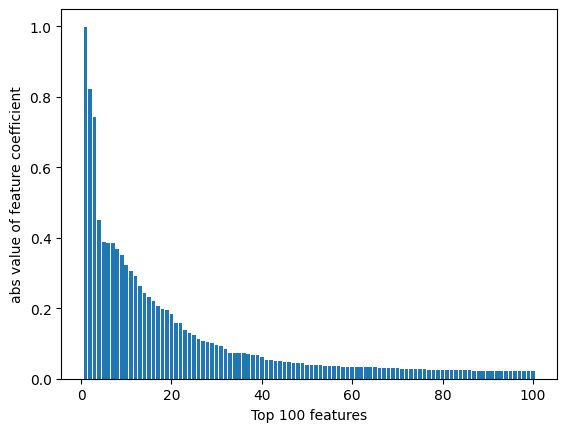

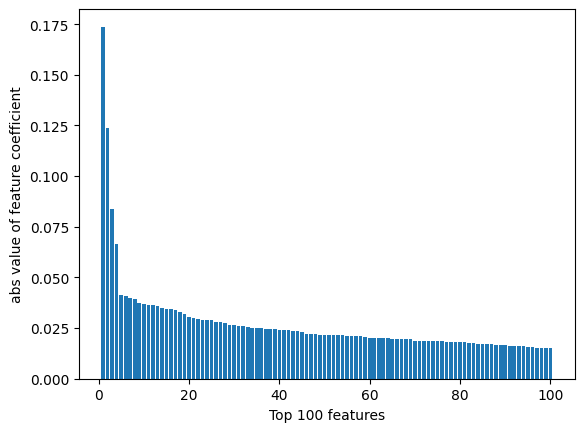

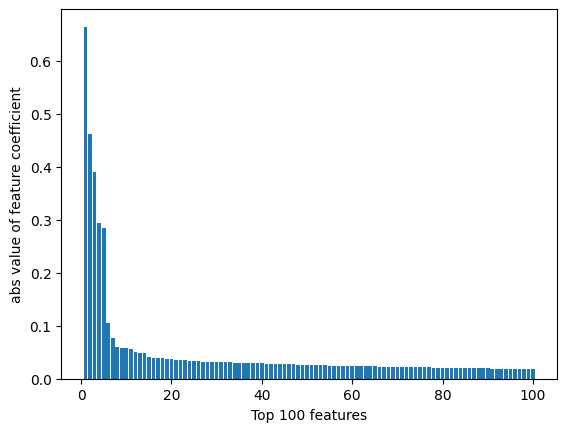

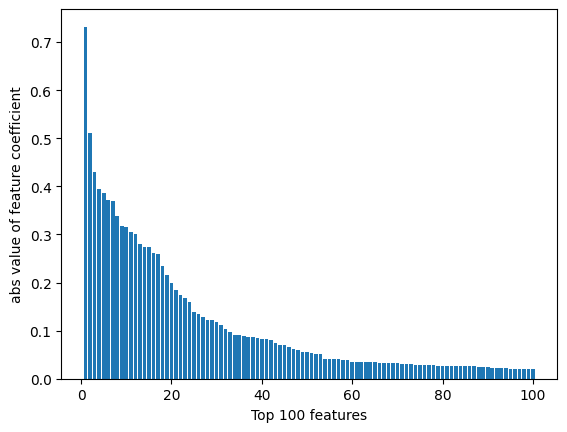

In [8]:
# PRE OPTIMIZATION
rs=[1]
for r in rs:
    print("r")
    print(r)
    for c in range(4):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:100]
        ax.bar(np.arange(1,101),np.abs(feature_weights[r-1][0][c])[inds])
        ax.set_xlabel("Top 100 features")
        ax.set_ylabel("abs value of feature coefficient")
        plt.show()

## 90th percentile

In [9]:
print(len(feature_weights))
print(len(feature_weights[0]))
print(feature_weights[0][0].shape)
np.array(feature_weights).shape

1
1
(4, 386)


(1, 1, 4, 386)

In [10]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(np.array(feature_weights, dtype=float)),axis=3)*0.90
sum90p.shape

(1, 1, 4)

In [12]:
topkinds = []
for r in range(1,2):
    topkinds_run = []
    for c in range(4):
        topkinds_conc = []
        curr_sum = 0
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c])) #desc
        sorted_weights = np.array(feature_weights)[r-1][0][c][inds]
        
        for ind, weight in zip(inds,sorted_weights):
            curr_sum += abs(weight)
            if curr_sum <= sum90p[r-1][0][c]:
                topkinds_conc.append(ind)
            else:
                break
        
        if len(topkinds_conc) < 10: # if selects less than 10, choose 10 best
            topkinds_conc = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:10].tolist()
        
        topkinds_run.append(topkinds_conc)
    topkinds.append(topkinds_run)

## Save to file

In [ ]:
# write top k inds to csv
for r in range(1,2):
    filename = dir_top_k + "topkindsr{}c4.csv".format(r)

    # writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)
        # writing the data rows 
        csvwriter.writerows(topkinds[r-1])